../Data/sensorA.mat
acetone
Split
RandomFlag
False


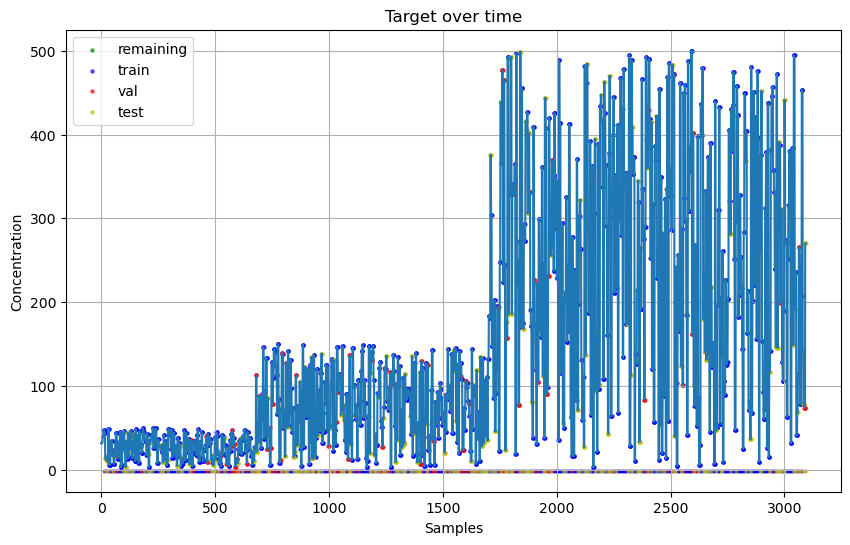

In [1]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import mean_squared_error
# Add the path to the folder containing the script
script_path = Path('../PreProcessing').resolve()
sys.path.insert(0, str(script_path))
import loadDataFull
script_path = Path('../Networks').resolve()
sys.path.insert(0, str(script_path))
from TCOCNN import TCOCNNClass

# DataLocation
locationData = "../Data/"

loadStruct = {}
# Struct DataLocation
loadStruct["fileNameDataAll"] = [locationData + "sensorA.mat"]
loadStruct["fileNameTargetAll"] = [locationData + "targets.mat"]

# Struct DataLocation
#loadStruct["fileNameDataAll"] = [locationData + "sensorA.mat",locationData + "sensorA.mat"]
#loadStruct["fileNameTargetAll"] = [locationData + "targets.mat",locationData + "targets.mat"]
loadStruct["targetGas"] = 'acetone'

# Used Method %see LoadDataFull 1: 70% 10% 20% Split
loadStruct["loadMethod"] = 1

# Expected Input Dimensions
loadStruct["dataSize"] = [4, 1440]

# Expected Output Dimensions
loadStruct["Outputsize"] = 1

# Specify Regression or Classification
loadStruct["Regression"] = True

# SaveFlag 
loadStruct["saveFlag"] = True

# Random Flag; False: Reproducible random Samples; True: in every execution Random
loadStruct["randomFlag"] = False

# NormalizeInput 
loadStruct["normFlag"] = True

loadStruct["OcclusionFlag"] = False

loadStruct["saveName"] = locationData + "Szenario_SA_1_Acetone.mat"

# Not the exact split is performed than in the original data (~20 UGMs less in test Set)
[data, target] = loadDataFull.load_Data_Full(loadStruct)

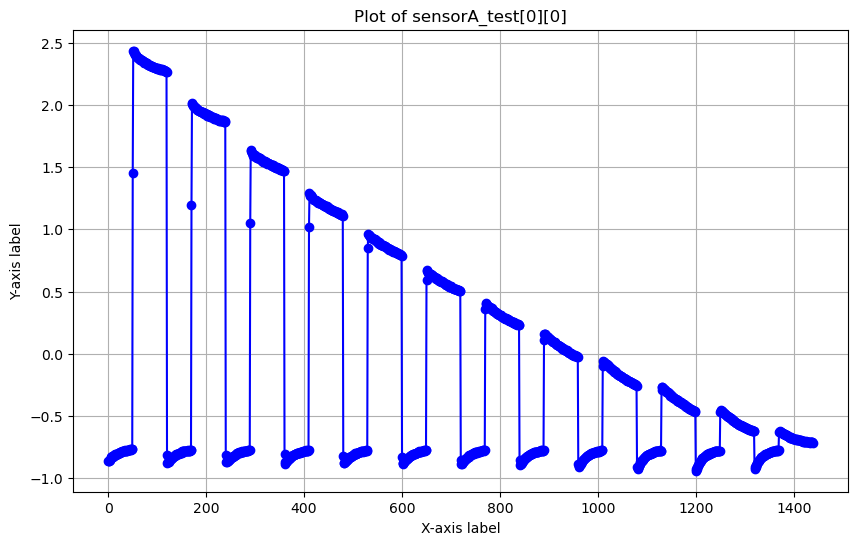

In [2]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(data["test"][0,0,:,0], marker='o', linestyle='-', color='b')  # Customize the plot as needed
plt.xlabel('X-axis label')  # Customize as needed
plt.ylabel('Y-axis label')  # Customize as needed
plt.title('Plot of sensorA_test[0][0]')  # Customize as needed
plt.grid(True)
plt.show()

In [3]:
with open('acetoneParams.json', 'r') as f:
        data_dict = json.load(f)

model = TCOCNNClass((4,1440,1), 1, regression=True)
model.build_net(data_dict)
model.compile_model(data_dict['initial_learning_rate'])
model.train(data['train'], target['train'])

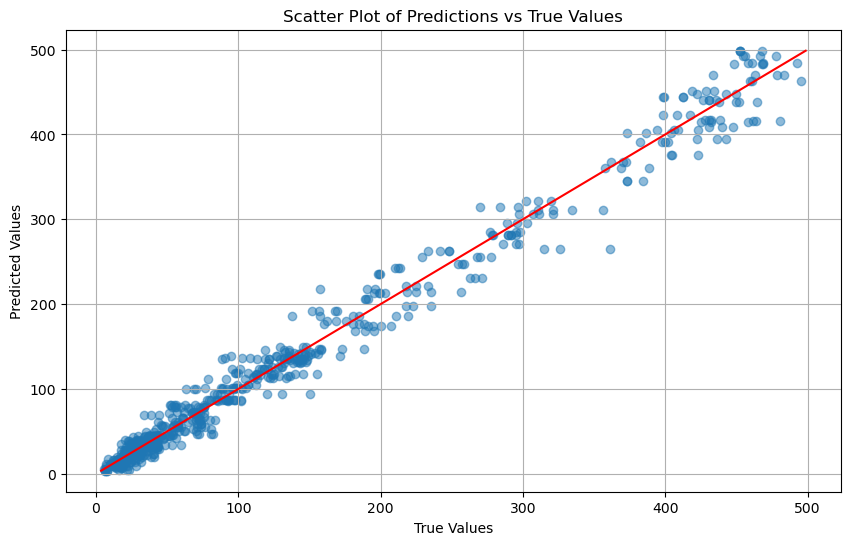

Root Mean Squared Error (RMSE): 17.517957696310916


In [4]:
pred = model.predict(data["test"])
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pred, target["test"], alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predictions vs True Values')
plt.plot([min(target["test"]), max(target["test"])], [min(target["test"]), max(target["test"])], color='red')  # Line of perfect prediction
plt.grid(True)
plt.show()
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(pred, target['test']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

In [5]:
occ = model.custom_occlusion(data['train'], data['val'])

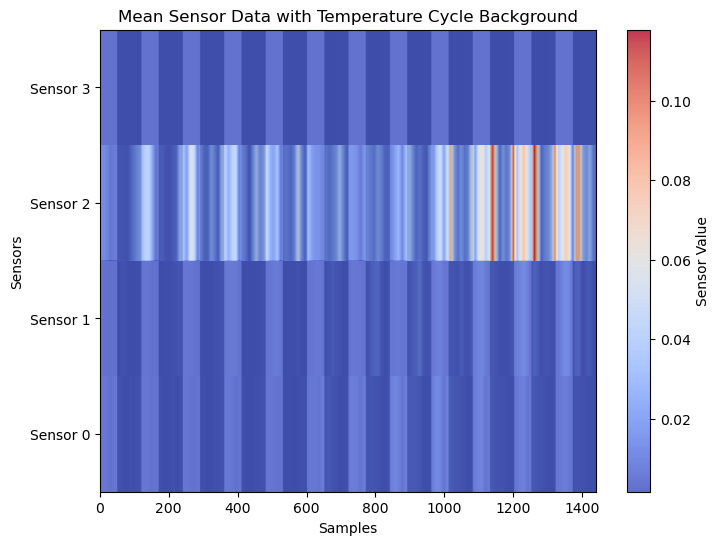

In [6]:
matrix = occ

# Take the mean across the first dimension (numberSamples)
mean_matrix = np.mean(matrix, axis=0).reshape(4, 1440)
# Flip the mean_matrix vertically
mean_matrix = np.flipud(mean_matrix)
# Create temperature cycle pattern
temperature_pattern = []
tempStart = 200
while len(temperature_pattern) < 1440:
    # High temperature phase (400 degrees for 50 samples)
    temperature_pattern.extend([400] * 50)
    temperature_pattern.extend([tempStart] * 70)
    tempStart = tempStart + 0

# Repeat the pattern for the full 1440 samples
temperature_cycle = np.tile(temperature_pattern, (4, 1))

# Plot the matrix with temperature cycle as background
plt.figure(figsize=(8, 6))


# Plot temperature cycle background
plt.imshow(temperature_cycle, cmap='gray', aspect='auto', alpha=0.7, extent=[0, 1440, 0, 4])

# Overlay mean sensor data with the same scale
for i in range(4):
    plt.imshow(mean_matrix[i:i+1, :], cmap='coolwarm', aspect='auto', alpha=0.8, extent=[0, 1440, i, i+1], vmin=np.min(mean_matrix), vmax=np.max(mean_matrix))

# Customize color bar and labels
plt.colorbar(label='Sensor Value')
plt.title('Mean Sensor Data with Temperature Cycle Background')
plt.xlabel('Samples')
plt.ylabel('Sensors')

# Customize y-ticks with sensor labels
sensor_labels = [f'Sensor {i}' for i in range(4)]
plt.yticks(ticks=np.arange(4)+0.5, labels=sensor_labels)

# Set y-axis limits to ensure none of the sensors are cut off
plt.ylim(0, 4)

plt.show()

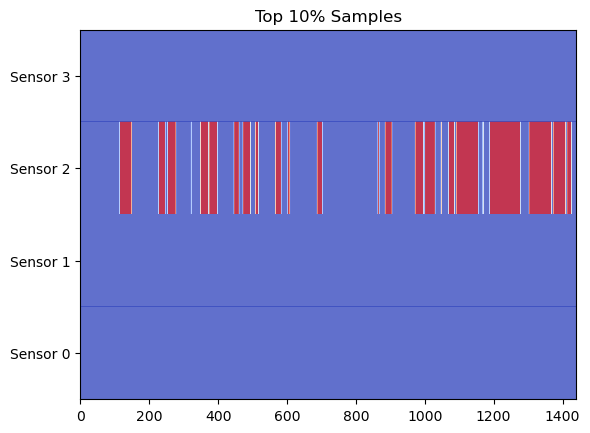

In [7]:
# Assuming your matrix is named 'my_matrix'
threshold = np.percentile(mean_matrix, 90)
selected_mask = mean_matrix >= threshold

# Create a binary mask where 'True' indicates top 10% samples
# Set the color of selected samples to white (1) and others to black (0)
image_data = np.where(selected_mask, 1, 0)



# Overlay mean sensor data with the same scale
for i in range(4):
    plt.imshow(image_data[i:i+1, :], cmap='coolwarm', aspect='auto', alpha=0.8, extent=[0, 1440, i, i+1], vmin=np.min(image_data), vmax=np.max(image_data))
plt.title("Top 10% Samples")


# Customize y-ticks with sensor labels
sensor_labels = [f'Sensor {i}' for i in range(4)]
plt.yticks(ticks=np.arange(4)+0.5, labels=sensor_labels)

# Set y-axis limits to ensure none of the sensors are cut off
plt.ylim(0, 4)

plt.show()

plt.show()

In [8]:
mean_train_sample = np.mean(data['train'], axis=0)

# Calculate the threshold for the top 10% of masking samples
thresholds = np.percentile(mean_matrix, 90)

# Create a boolean mask
top_mask = mean_matrix >= threshold

# Replace top samples with reference samples
# Assuming you have 'reference_samples' of the same shape as observations
top_mask = np.expand_dims(top_mask, axis=-1)

# Broadcast and replace top samples with reference samples
data_without = {}
data_without['train'] = np.where(top_mask, mean_train_sample, data['train'])
data_without['val'] = np.where(top_mask, mean_train_sample, data['val'])
data_without['test'] = np.where(top_mask, mean_train_sample, data['test'])

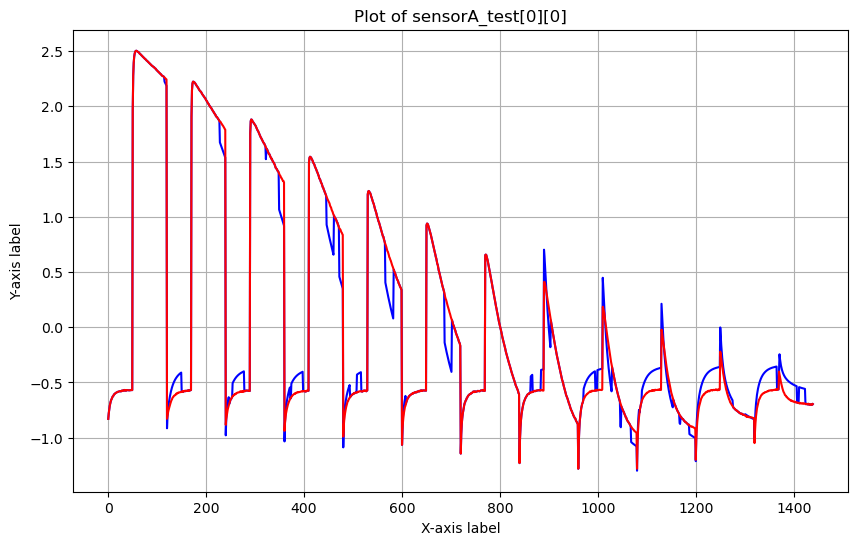

In [9]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(data_without['train'][0,2,:,0], linestyle='-', color='b')  # Customize the plot as needed
plt.plot(data['train'][0,2,:,0], linestyle='-', color='r')  # Customize the plot as needed
plt.xlabel('X-axis label')  # Customize as needed
plt.ylabel('Y-axis label')  # Customize as needed
plt.title('Plot of sensorA_test[0][0]')  # Customize as needed
plt.grid(True)
plt.show()

In [10]:
with open('acetoneParams.json', 'r') as f:
        data_dict = json.load(f)

model_without = TCOCNNClass((4,1440,1), 1, regression=True)
model_without.build_net(data_dict)
model_without.compile_model(data_dict['initial_learning_rate'])
model_without.train(data_without['train'], target['train'])

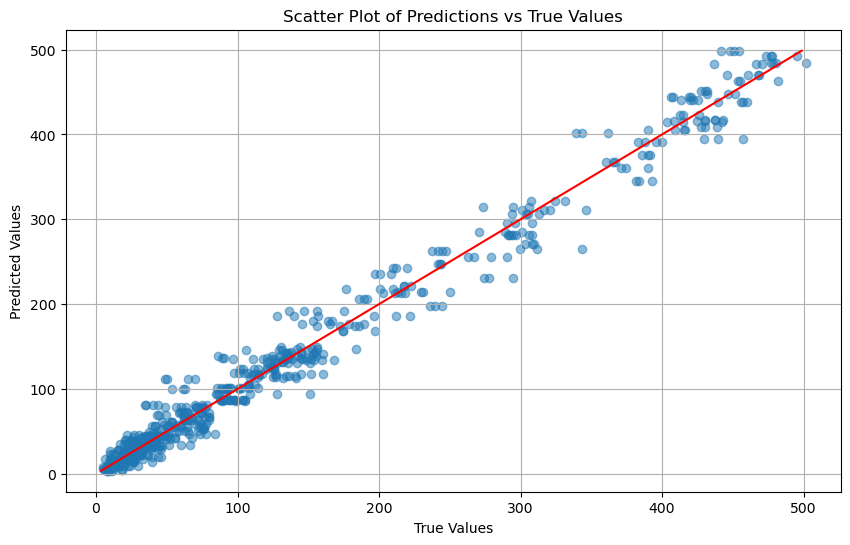

Root Mean Squared Error (RMSE): 18.45647843167841


In [11]:
pred = model_without.predict(data_without["test"])
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pred, target["test"], alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predictions vs True Values')
plt.plot([min(target["test"]), max(target["test"])], [min(target["test"]), max(target["test"])], color='red')  # Line of perfect prediction
plt.grid(True)
plt.show()
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(pred, target['test']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

In [12]:
mean_train_sample = np.mean(data['train'], axis=0)

# Calculate the threshold for the top 10% of masking samples
thresholds = np.percentile(mean_matrix, 90)

# Create a boolean mask
top_mask = mean_matrix < threshold

# Replace top samples with reference samples
# Assuming you have 'reference_samples' of the same shape as observations
top_mask = np.expand_dims(top_mask, axis=-1)

# Broadcast and replace top samples with reference samples
data_with = {}
data_with['train'] = np.where(top_mask, mean_train_sample, data['train'])
data_with['val'] = np.where(top_mask, mean_train_sample, data['val'])
data_with['test'] = np.where(top_mask, mean_train_sample, data['test'])

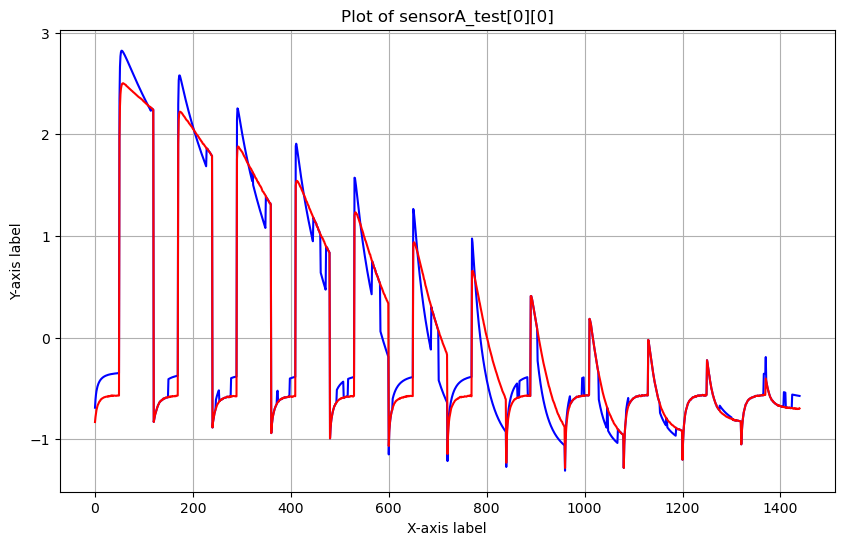

In [13]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(data_with['train'][0,2,:,0], linestyle='-', color='b')  # Customize the plot as needed
plt.plot(data['train'][0,2,:,0], linestyle='-', color='r')  # Customize the plot as needed
plt.xlabel('X-axis label')  # Customize as needed
plt.ylabel('Y-axis label')  # Customize as needed
plt.title('Plot of sensorA_test[0][0]')  # Customize as needed
plt.grid(True)
plt.show()

In [19]:
with open('acetoneParams.json', 'r') as f:
        data_dict = json.load(f)

model_with = TCOCNNClass((4,1440,1), 1, regression=True)
model_with.build_net(data_dict)
model_with.compile_model(data_dict['initial_learning_rate'])
model_with.train(data_with['train'], target['train'])

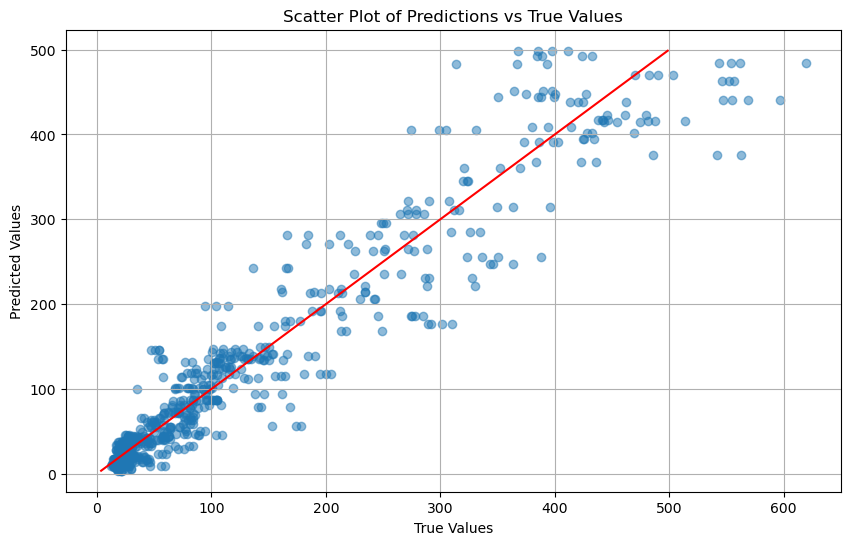

Root Mean Squared Error (RMSE): 42.4165302171798


In [20]:
pred = model_with.predict(data_with["test"])
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pred, target["test"], alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predictions vs True Values')
plt.plot([min(target["test"]), max(target["test"])], [min(target["test"]), max(target["test"])], color='red')  # Line of perfect prediction
plt.grid(True)
plt.show()
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(pred, target['test']))
print(f'Root Mean Squared Error (RMSE): {rmse}')

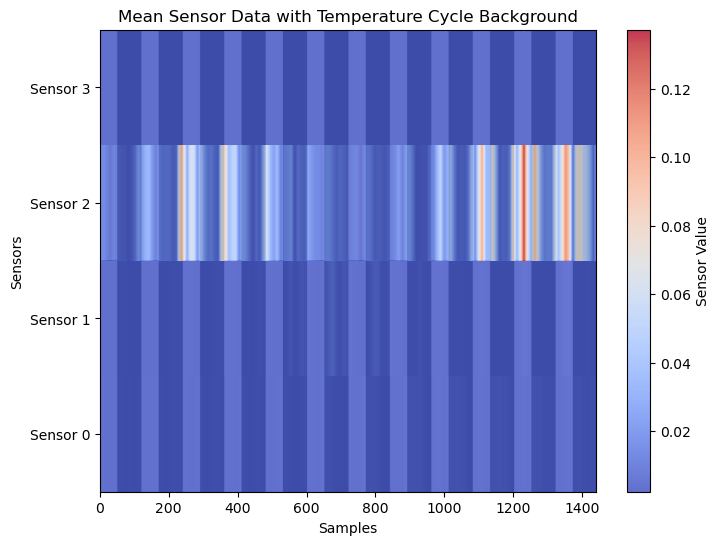

In [16]:
sample = data_without['val']
occ = model_without.custom_occlusion(data['train'], data['val'])
matrix = occ

# Take the mean across the first dimension (numberSamples)
mean_matrix = np.mean(matrix, axis=0).reshape(4, 1440)
# Flip the mean_matrix vertically
mean_matrix = np.flipud(mean_matrix)
# Create temperature cycle pattern
temperature_pattern = []
tempStart = 200
while len(temperature_pattern) < 1440:
    # High temperature phase (400 degrees for 50 samples)
    temperature_pattern.extend([400] * 50)
    temperature_pattern.extend([tempStart] * 70)
    tempStart = tempStart + 0

# Repeat the pattern for the full 1440 samples
temperature_cycle = np.tile(temperature_pattern, (4, 1))

# Plot the matrix with temperature cycle as background
plt.figure(figsize=(8, 6))


# Plot temperature cycle background
plt.imshow(temperature_cycle, cmap='gray', aspect='auto', alpha=0.7, extent=[0, 1440, 0, 4])

# Overlay mean sensor data with the same scale
for i in range(4):
    plt.imshow(mean_matrix[i:i+1, :], cmap='coolwarm', aspect='auto', alpha=0.8, extent=[0, 1440, i, i+1], vmin=np.min(mean_matrix), vmax=np.max(mean_matrix))

# Customize color bar and labels
plt.colorbar(label='Sensor Value')
plt.title('Mean Sensor Data with Temperature Cycle Background')
plt.xlabel('Samples')
plt.ylabel('Sensors')

# Customize y-ticks with sensor labels
sensor_labels = [f'Sensor {i}' for i in range(4)]
plt.yticks(ticks=np.arange(4)+0.5, labels=sensor_labels)

# Set y-axis limits to ensure none of the sensors are cut off
plt.ylim(0, 4)

plt.show()

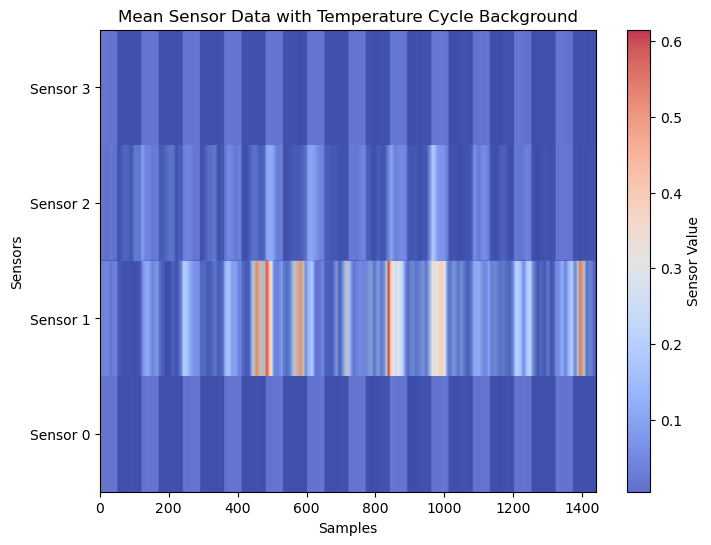

In [22]:
sample = data_with['val']
occ = model_with.custom_occlusion(data['train'], data['val'])
matrix = occ

# Take the mean across the first dimension (numberSamples)
mean_matrix = np.mean(abs(matrix), axis=0).reshape(4, 1440)
# Flip the mean_matrix vertically
mean_matrix = np.flipud(mean_matrix)
# Create temperature cycle pattern
temperature_pattern = []
tempStart = 200
while len(temperature_pattern) < 1440:
    # High temperature phase (400 degrees for 50 samples)
    temperature_pattern.extend([400] * 50)
    temperature_pattern.extend([tempStart] * 70)
    tempStart = tempStart + 0

# Repeat the pattern for the full 1440 samples
temperature_cycle = np.tile(temperature_pattern, (4, 1))

# Plot the matrix with temperature cycle as background
plt.figure(figsize=(8, 6))


# Plot temperature cycle background
plt.imshow(temperature_cycle, cmap='gray', aspect='auto', alpha=0.7, extent=[0, 1440, 0, 4])

# Overlay mean sensor data with the same scale
for i in range(4):
    plt.imshow(mean_matrix[i:i+1, :], cmap='coolwarm', aspect='auto', alpha=0.8, extent=[0, 1440, i, i+1], vmin=np.min(mean_matrix), vmax=np.max(mean_matrix))

# Customize color bar and labels
plt.colorbar(label='Sensor Value')
plt.title('Mean Sensor Data with Temperature Cycle Background')
plt.xlabel('Samples')
plt.ylabel('Sensors')

# Customize y-ticks with sensor labels
sensor_labels = [f'Sensor {i}' for i in range(4)]
plt.yticks(ticks=np.arange(4)+0.5, labels=sensor_labels)

# Set y-axis limits to ensure none of the sensors are cut off
plt.ylim(0, 4)

plt.show()